In [1]:
# file locations
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz") # for libs.plotting
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [3]:
X_test_files =  ["AirNow_PM25_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{path + file}" for file in X_train_files]
Y_training_files_paths = f"{path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
'''
Y_train = Y_train[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_test = Y_test[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_valid = Y_valid[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
'''
Y_train = Y_train[:, :1, [sensor['North Holywood']]].copy()
Y_test = Y_test[:, :1, [sensor['North Holywood']]].copy()
Y_valid = Y_valid[:, :1, [sensor['North Holywood']]].copy()

In [6]:
output_frames, output_stations = Y_train.shape[1:]
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

X_train shape: (12275, 5, 40, 40, 1)
Y_train shape: (12275, 1, 1)

X_test shape:  (2630, 5, 40, 40, 1)
Y_test shape:  (2630, 1, 1)

X_valid shape: (2630, 5, 40, 40, 1)
Y_valid shape: (2630, 1, 1)

Input shape:   (5, 40, 40, 1)
Output shape:  (1, 1)



# Plots

## Snapshot plots - first frame

In [7]:
import pandas as pd
dates = pd.date_range(START_DATE, END_DATE, freq='h')
'''train-valid-test
y_train_dates = dates[frames_per_sample: len(Y_train)+frames_per_sample]
y_valid_dates = dates[len(Y_train)+frames_per_sample : len(Y_train)+frames_per_sample + len(Y_valid)]
y_test_dates = dates[len(Y_train)+frames_per_sample + len(Y_valid)+frames_per_sample :]
'''
''' valid-test-train '''
y_valid_dates = dates[frames_per_sample : len(Y_valid) + frames_per_sample]
y_test_dates = dates[len(Y_valid) + frames_per_sample : len(Y_valid) + frames_per_sample + len(Y_test)]
y_train_dates = dates[len(Y_valid) + frames_per_sample + len(Y_test) + frames_per_sample :]

print(len(y_train_dates), len(y_valid_dates), len(y_test_dates))
print(len(Y_train), len(Y_valid), len(Y_test))

y_test_start_idx = len(X_train) + len(X_valid)
y_valid_start_idx = len(X_train)
print(y_valid_start_idx, y_test_start_idx)
print(len(dates))

12275 2630 2630
12275 2630 2630
12275 14905
17545


In [8]:
print(
    f"Percent of data containing zeros:\n",
    f"\tTrain: {len(np.where(Y_train == 0)[0]) / len(Y_train) * 100:.2f}%\n",
    f"\tValid: {len(np.where(Y_valid == 0)[0]) / len(Y_valid) * 100:.2f}%\n",
    f"\tTest : {len(np.where(Y_test == 0)[0]) / len(Y_test) * 100:.2f}%\n",
)

print(
    f"Data statistics:\n",
    f"\tTrain mean/std: {Y_train.mean():.2f}, {Y_train.std():.2f}\n",
    f"\tValid mean/std: {Y_valid.mean():.2f}, {Y_valid.std():.2f}\n",
    f"\tTest mean/std : {Y_test.mean():.2f}, {Y_test.std():.2f}\n",
)

Percent of data containing zeros:
 	Train: 2.34%
 	Valid: 1.67%
 	Test : 0.84%

Data statistics:
 	Train mean/std: 10.91, 7.25
 	Valid mean/std: 8.41, 5.85
 	Test mean/std : 9.64, 6.30



## Rolling avg plots

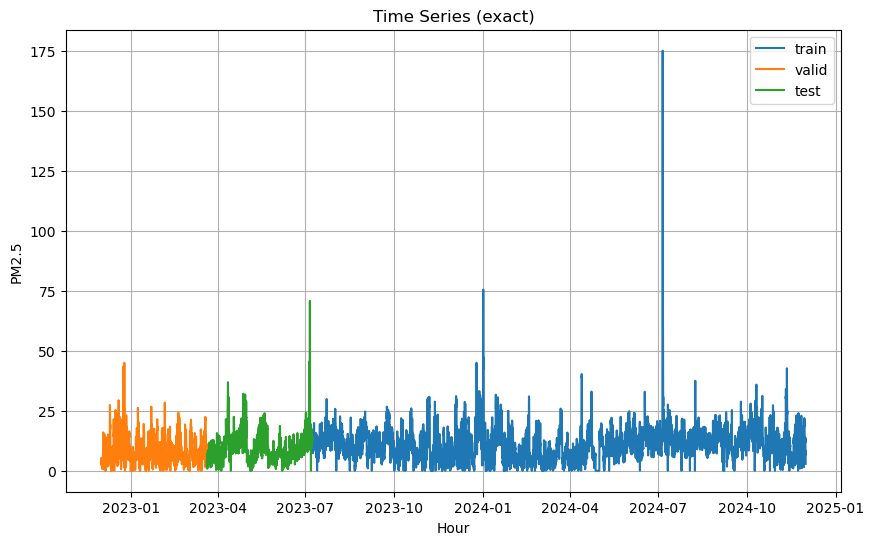

In [9]:
# underlying data distribution
plt.figure(figsize=(10, 6))
#plt.plot(dates, np.squeeze(np.concatenate([Y_train, Y_valid, Y_test])))
plt.plot(y_train_dates, np.squeeze(Y_train), label=f'train')
plt.plot(y_valid_dates, np.squeeze(Y_valid), label=f'valid')
plt.plot(y_test_dates, np.squeeze(Y_test), label=f'test')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

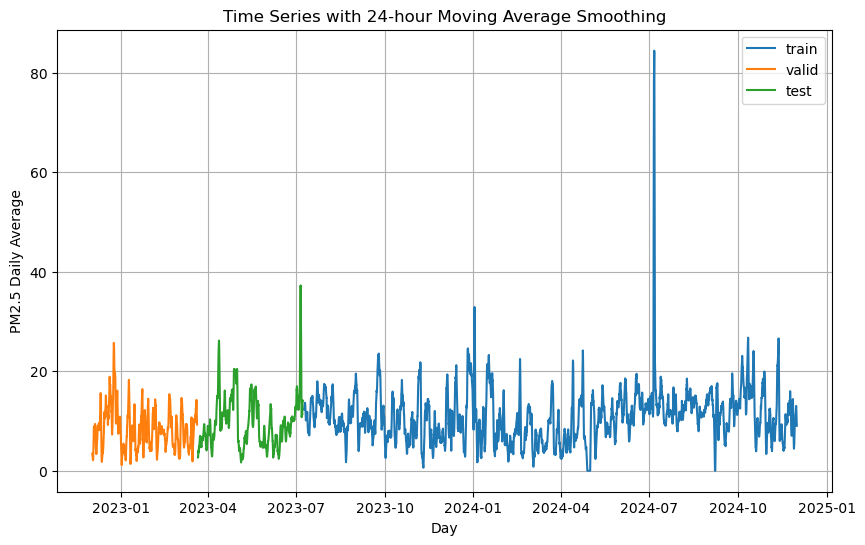

In [10]:
series_train = pd.Series(np.squeeze(np.squeeze(Y_train)))
series_valid = pd.Series(np.squeeze(np.squeeze(Y_valid)))
series_test = pd.Series(np.squeeze(np.squeeze(Y_test)))

window_size = 24 # daily average
smoothed_train = series_train.rolling(window=window_size).mean()
smoothed_valid = series_valid.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(y_train_dates, smoothed_train, label=f'train')
plt.plot(y_valid_dates, smoothed_valid, label=f'valid')
plt.plot(y_test_dates, smoothed_test, label=f'test')

plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

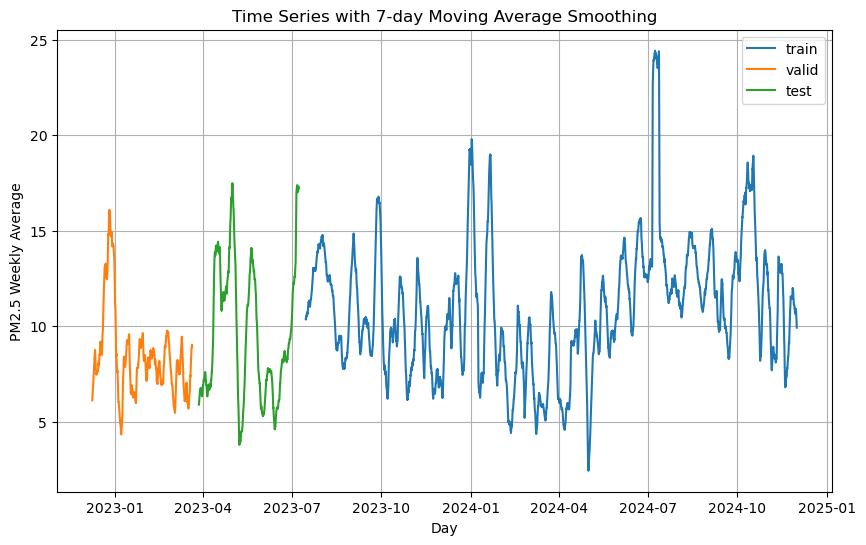

In [11]:
window_size = 24*7 # weekly average
smoothed_train = series_train.rolling(window=window_size).mean()
smoothed_valid = series_valid.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(y_train_dates, smoothed_train, label=f'train')
plt.plot(y_valid_dates, smoothed_valid, label=f'valid')
plt.plot(y_test_dates, smoothed_test, label=f'test')

plt.title('Time Series with 7-day Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

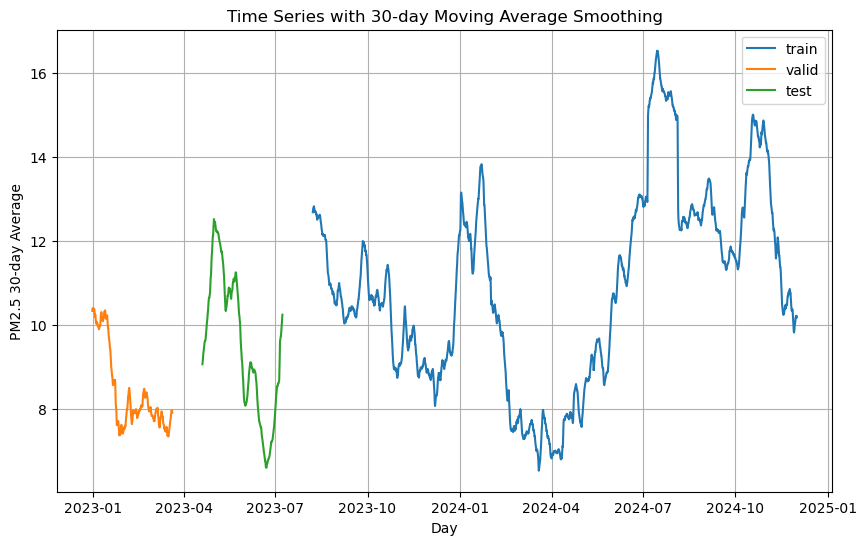

In [12]:
window_size = 24*30 # 30-day average
smoothed_train = series_train.rolling(window=window_size).mean()
smoothed_valid = series_valid.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(y_train_dates, smoothed_train, label=f'train')
plt.plot(y_valid_dates, smoothed_valid, label=f'valid')
plt.plot(y_test_dates, smoothed_test, label=f'test')

plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Etc

In [13]:
print(f"Train Mean: {Y_train.mean():.2f}")
print(f"Validation Mean: {Y_valid.mean():.2f}")
print(f"Test Mean: {Y_test.mean():.2f}")
print()
print(f"Train Std: {Y_train.std():.2f}")
print(f"Validation Std: {Y_valid.std():.2f}")
print(f"Test Std: {Y_test.std():.2f}")

Train Mean: 10.91
Validation Mean: 8.41
Test Mean: 9.64

Train Std: 7.25
Validation Std: 5.85
Test Std: 6.30
